#### Importando bibliotecas necessárias

In [44]:
import sys
import polars as pl
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import math

sys.path.append('D:\\__case_ifood\\notebooks\\utils') # Defina aqui a pasta


In [113]:
import importlib
import utils

# Recarregar o módulo 'utils'
importlib.reload(utils)

from utils import get_sales_data_some_columns, calculate_evaluation_metrics, calculate_engagement_custormers_two_orders, calculate_engagement_custormers_three_orders, calculate_engagement_custormers_three_plus_orders


### A) – Definição de segmentações relevantes para o teste A/B

A segmentação de usuários permite refinar a análise do impacto da campanha de cupons, identificando **grupos específicos** em que a ação foi mais ou menos eficaz. A seguir, estão os segmentos definidos com suas respectivas justificativas e critérios:

---

#### Segmentos utilizados

| Segmento                           | Justificativa Estratégica                                                                 |
|------------------------------------|--------------------------------------------------------------------------------------------|
| **Cidade de entrega**              | Diferenças regionais foram nítidas nos resultados, com destaque em Cohen's d por cidade    |
| **Faixa de preço do restaurante**     | Indica o ticket médio esperado; reflete a sensibilidade a descontos                        |
| **Tempo de entrega do restaurante**| Pode impactar a percepção de valor e satisfação com a experiência de compra                |
| **Origem do pedido**               | Canais distintos (web vs. mobile) podem ter padrões de comportamento diferentes            |

---

### B) Critérios utilizados por segmento

- **Cidade de entrega:**  
  Selecionadas as 9 principais cidades com maior volume de pedidos na base.

- **Faixa de preço do restaurante (`price_range`):**  
  Utilização direta da variável existente. o range do preço por restaurante pode ser relevante para buscar insights não identificados.

- **Tempo de entrega do restaurante (`delivery_time`):**  
  Criação de faixas com base em quantis ou limiares como:  
  - Até 30 minutos → entrega rápida  
  - De 31 a 50 minutos → entrega moderada  
  - Acima de 50 minutos → entrega lenta

- **Origem do pedido (`origin_platform`):**  
  Agrupamento pelas categorias disponíveis na base, como `web`, `mobile`, `other`.

---

Essas segmentações serão utilizadas para analisar as métricas de desempenho da campanha (ARPU, engajamento), com o objetivo de identificar **grupos com maior retorno** e possíveis **oportunidades de personalização futura**.

In [ ]:
# Busca os dados necessários
df_sales = get_sales_data_some_columns()

### C) Análise dos resultados

#### 1) Por cidade de entrega

##### ARPU

In [104]:
df_evaluation_metrics_by_address_city = calculate_evaluation_metrics(df_sales, "delivery_address_city")

In [98]:
# repurchase customers

df_customers_with_2_orders = calculate_engagement_custormers_two_orders(df_sales, "delivery_address_city")

df_customers_with_3_orders = calculate_engagement_custormers_three_orders(df_sales, "delivery_address_city")

df_customers_with_3_plus_orders = calculate_engagement_custormers_three_plus_orders(df_sales, "delivery_address_city")

In [19]:
# Join DFs

df_evaluation_metrics_by_address_city = df_evaluation_metrics_by_address_city.join(
    df_customers_with_2_orders,
    on=["is_target","delivery_address_city"],
    how="left"
).with_columns([
    (pl.col("customers_with_2_orders") / pl.col("unique_customers")).round(3).alias("percent_customers_with_2_orders")
]).join(
    df_customers_with_3_orders,
    on=["is_target","delivery_address_city"],
    how="left"
).with_columns([
    (pl.col("customers_with_3_orders") / pl.col("unique_customers")).round(3).alias("percent_customers_with_3_orders")
]).join(
    df_customers_with_3_plus_orders,
    on=["is_target","delivery_address_city"],
    how="left"
).with_columns([
    (pl.col("customers_with_3_plus_orders") / pl.col("unique_customers")).round(3).alias("percent_customers_with_3_plus_orders")
]
)

C:\Users\fsgon\AppData\Local\Temp\ipykernel_1352\2422142694.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_em_pandas, x="percent_revenue", y="delivery_address_city", palette="viridis")


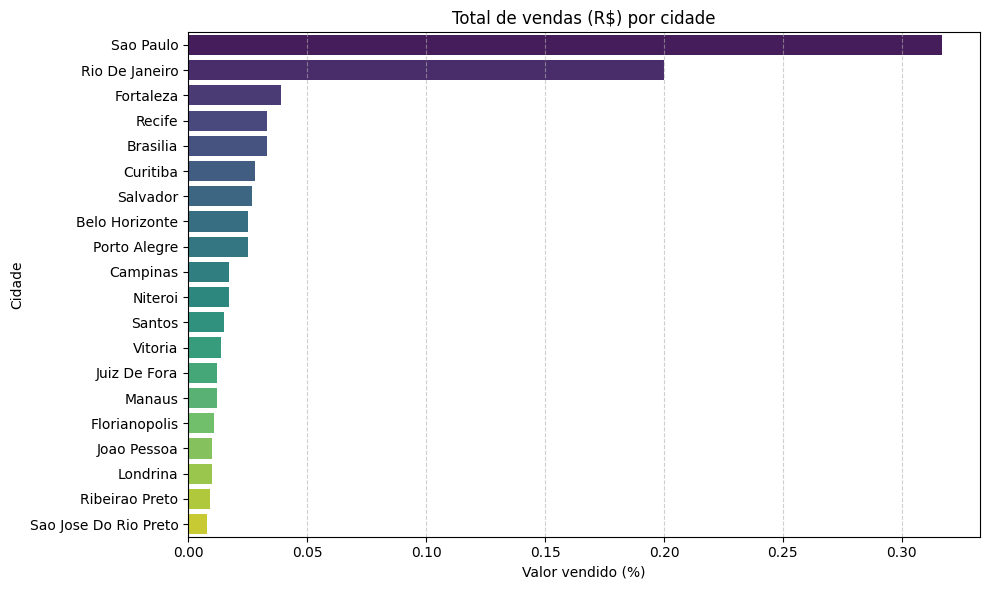

In [ ]:
df_em_pandas = df_evaluation_metrics_by_address_city.group_by("delivery_address_city").agg([
    pl.col("revenue").sum().alias("total_amount")
]).with_columns([
    (pl.col("total_amount") / pl.col("total_amount").sum()).round(3).alias("percent_revenue"),
    pl.col("total_amount").rank("ordinal",descending=True).alias("rn")
]).filter(pl.col("rn") <= 20).select("delivery_address_city","total_amount","percent_revenue").to_pandas()

df_em_pandas= df_em_pandas.sort_values(by="total_amount", ascending=False)

# Plotar gráfico
plt.figure(figsize=(10, 6))
sns.barplot(data=df_em_pandas, x="percent_revenue", y="delivery_address_city", palette="viridis")

plt.title("Total de vendas (R$ %) por cidade")
plt.xlabel("Valor vendido (%)")
plt.ylabel("Cidade")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [36]:
# A partir do gráfico acima, irei considerar as primeiras 9 cidades para avaliar as métricas ARPU e Engajamento (Recompra)

cities = ["Sao Paulo", "Rio De Janeiro", "Belo Horizonte", "Curitiba", 
           "Recife", "Salvador", "Brasilia", "Fortaleza","Porto Alegre"]

In [39]:


# Lista para armazenar os resultados
results = []

# Laço para processar cada cidade
for city in cities:
    df_city = df_evaluation_metrics_by_address_city.filter(pl.col("delivery_address_city") == city)

    serie_target = df_city.filter(pl.col("is_target") == "target")["ARPU"]
    serie_control = df_city.filter(pl.col("is_target") == "control")["ARPU"]

    # Verifica se ambas as séries têm valor
    if len(serie_target) == 1 and len(serie_control) == 1:
        arpu_target_val = serie_target.item()
        arpu_control_val = serie_control.item()

        diff_abs = arpu_target_val - arpu_control_val
        diff_pct = (arpu_target_val / arpu_control_val - 1) if arpu_control_val != 0 else None

        results.append({
            "city": city,
            "ARPU_target": round(arpu_target_val, 2),
            "ARPU_control": round(arpu_control_val, 2),
            "absolute_diff": round(diff_abs, 2),
            "percent_diff": round(diff_pct * 100, 2) if diff_pct is not None else None
        })
    else:
        print(f"Aviso: Dados ausentes para '{city}' em um dos grupos. Pulando.")
# Converter lista de resultados em DataFrame Polars
df_arpu_by_city = pl.DataFrame(results)

C:\Users\fsgon\AppData\Local\Temp\ipykernel_1352\4074509797.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_arpu_by_city_pd, x="absolute_diff", y="city", palette="viridis")


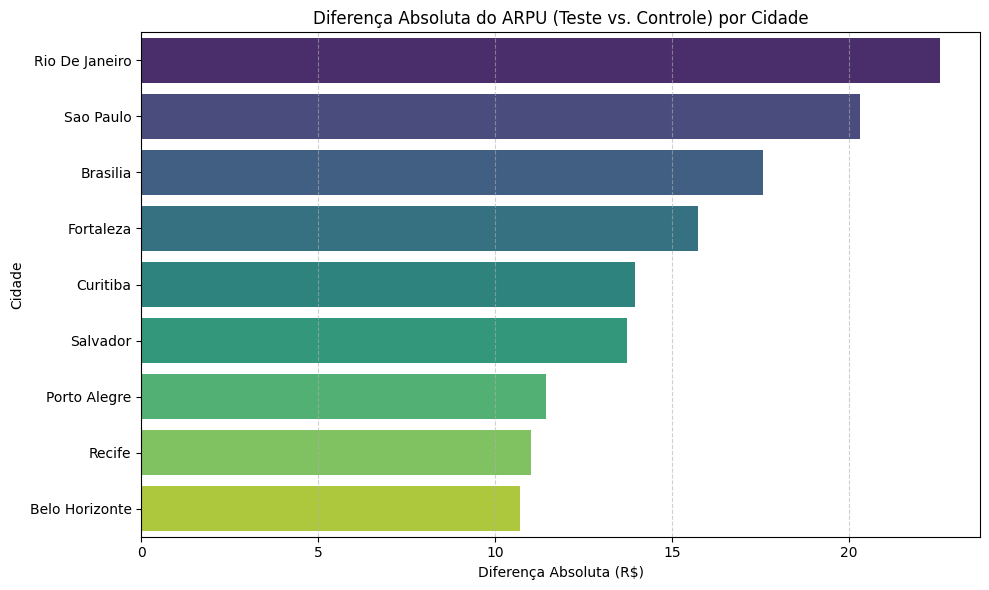

In [40]:
df_arpu_by_city_pd = df_arpu_by_city.to_pandas()

# Ordenar do maior para o menor
df_arpu_by_city_pd = df_arpu_by_city_pd.sort_values(by="absolute_diff", ascending=False)

# Plotar gráfico
plt.figure(figsize=(10, 6))
sns.barplot(data=df_arpu_by_city_pd, x="absolute_diff", y="city", palette="viridis")

plt.title("Diferença Absoluta do ARPU (Teste vs. Controle) por Cidade")
plt.xlabel("Diferença Absoluta (R$)")
plt.ylabel("Cidade")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [41]:
result_std_by_city = []

for city in cities:
    df_std_arpu_city = (
        df_sales
        .filter(pl.col("delivery_address_city") == city)
        .group_by(["delivery_address_city", "is_target"])  # ← corrigido aqui
        .agg([
            pl.col("amount").std().alias("std_arpu")
        ])
    )

    if df_std_arpu_city.height == 2:
        grupo_test = df_std_arpu_city.filter(pl.col("is_target") == "target")
        grupo_control = df_std_arpu_city.filter(pl.col("is_target") == "control")

        std_test = grupo_test["std_arpu"].item()
        std_control = grupo_control["std_arpu"].item()

        result_std_by_city.append({
            "city": city,
            "std_test": std_test,
            "std_control": std_control
        })

df_std_arpu_by_city = pl.DataFrame(result_std_by_city)

In [43]:
df_evaluation_metrics_by_address_city = df_evaluation_metrics_by_address_city.join(
    df_std_arpu_by_city,
    left_on=["delivery_address_city"],
    right_on=["city"],
    how="left"
)

In [ ]:
# Calculating Cohen's d statistic for ARPU to measure effect size
# Cohen's d is a measure of effect size that indicates the difference between two means in terms of standard deviations.
# It is calculated as the difference between the means divided by the pooled standard deviation.

results_cohens_by_city = []

for city in cities:

    arpu_target_city = df_evaluation_metrics_by_address_city.filter(pl.col("is_target") == "target", pl.col("delivery_address_city") == city)["ARPU"].item()
    arpu_control_city = df_evaluation_metrics_by_address_city.filter(pl.col("is_target") == "control", pl.col("delivery_address_city") == city)["ARPU"].item()
    sd_target_city = df_evaluation_metrics_by_address_city.filter(pl.col("is_target") == "target", pl.col("delivery_address_city") == city)["std_test"].item()
    sd_control_city = df_evaluation_metrics_by_address_city.filter(pl.col("is_target") == "control", pl.col("delivery_address_city") == city)["std_control"].item()

    cohen_d = round((arpu_target_city - arpu_control_city) / (math.sqrt(((sd_target_city**2 + sd_control_city**2) / 2))),5)

    results_cohens_by_city.append({
        "city":city,
        "cohens_d":cohen_d
    })

df_cohens_by_city = pl.DataFrame(results_cohens_by_city)

Cidade: Sao Paulo | Cohen's d: 0.34005
Cidade: Rio De Janeiro | Cohen's d: 0.44655
Cidade: Belo Horizonte | Cohen's d: 0.09537
Cidade: Curitiba | Cohen's d: 0.50621
Cidade: Recife | Cohen's d: 0.44627
Cidade: Salvador | Cohen's d: 0.47726
Cidade: Brasilia | Cohen's d: 0.58418
Cidade: Fortaleza | Cohen's d: 0.64122
Cidade: Porto Alegre | Cohen's d: 0.29869


In [60]:
df_cohens_by_city = df_cohens_by_city.with_columns([
    pl.when(pl.col("cohens_d") < 0.2).then(pl.lit("Muito pequeno"))
     .when(pl.col("cohens_d") < 0.5).then(pl.lit("Pequeno"))
     .when(pl.col("cohens_d") < 0.8).then(pl.lit("Médio"))
     .otherwise(pl.lit("Grande"))
     .alias("classificacao_efeito")
])

In [ ]:
df_evaluation_metrics_by_address_city = df_evaluation_metrics_by_address_city.join(
    df_cohens_by_city,
    left_on="delivery_address_city",
    right_on="city",
    how="left"
)

df_arpu_by_city = df_arpu_by_city.join(
    df_cohens_by_city,
    on="city",
    how="left"
)

is_target,delivery_address_city,orders,unique_customers,revenue,TKM,ARPU,total_revenue,total_orders,total_customers,customers_with_2_orders,percent_customers_with_2_orders,customers_with_3_orders,percent_customers_with_3_orders,customers_with_3_plus_orders,percent_customers_with_3_plus_orders,std_test,std_control,cohens_d,classificacao_efeito
str,str,u32,u32,f64,f64,f64,f64,u32,u32,u32,f64,u32,f64,u32,f64,f64,f64,f64,str
"""target""","""Mesquita""",403,188,13823.6,34.3,73.53,25271.59,747,346,45,0.239,21,0.112,25,0.133,null,null,null,null
"""target""","""Canoas""",1808,772,70579.24,39.04,91.42,126801.81,3263,1455,159,0.206,88,0.114,117,0.152,null,null,null,null
"""target""","""Volta Redonda""",4301,1720,152421.86,35.44,88.62,271095.74,7575,3143,378,0.22,199,0.116,339,0.197,null,null,null,null
"""target""","""Atibaia""",33,26,1549.0,46.94,59.58,3125.3,68,56,7,0.269,null,null,null,null,null,null,null,null
"""target""","""Osasco""",7053,2915,327698.23,46.46,112.42,563936.4,12103,5266,610,0.209,306,0.105,528,0.181,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""control""","""Aracaju""",1951,964,71575.35,36.69,74.25,173124.15,4802,2124,157,0.163,66,0.068,125,0.13,null,null,null,null
"""control""","""Santarem""",3,3,134.5,44.83,44.83,255.9,6,6,null,null,null,null,null,null,null,null,null,null
"""control""","""Sao Leopoldo""",106,60,3464.3,32.68,57.74,7972.01,228,130,6,0.1,2,0.033,7,0.117,null,null,null,null


In [73]:
# Inicializa uma lista para armazenar os novos valores de 'unique_customers'
updated_values = []

for city in cities:
    # Filtra os dados para a cidade e 'is_target' == 'target'
    filtered_data = df_evaluation_metrics_by_address_city.filter(
        (pl.col("is_target") == "target") & (pl.col("delivery_address_city") == city)
    )
    
    # Obtém o valor de 'unique_customers' da cidade filtrada
    if filtered_data.shape[0] > 0:
        unique_customers_value = filtered_data["unique_customers"].item()  # Pega o valor de 'unique_customers'
    else:
        unique_customers_value = 0  # Se não houver dados, atribui um valor padrão

    # Adiciona o valor à lista de valores atualizados para 'unique_customers'
    updated_values.append((city, unique_customers_value))

# Agora, atualize o df_arpu_by_city com os novos valores
for city, unique_customers_value in updated_values:
    df_arpu_by_city = df_arpu_by_city.with_columns(
        pl.when(pl.col("city") == city)
        .then(pl.lit(unique_customers_value))
        .otherwise(pl.col("unique_customers"))
        .alias("unique_customers")
    )


In [80]:
print(df_arpu_by_city.select(pl.col("city"), pl.col("absolute_diff"), pl.col("unique_customers")).with_columns([
    ((pl.col("absolute_diff") - 15) * pl.col("unique_customers")).round(0).alias("revenue_estimated")
])
)

shape: (9, 4)
┌────────────────┬───────────────┬──────────────────┬───────────────────┐
│ city           ┆ absolute_diff ┆ unique_customers ┆ revenue_estimated │
│ ---            ┆ ---           ┆ ---              ┆ ---               │
│ str            ┆ f64           ┆ i32              ┆ f64               │
╞════════════════╪═══════════════╪══════════════════╪═══════════════════╡
│ Sao Paulo      ┆ 20.32         ┆ 122492           ┆ 651657.0          │
│ Rio De Janeiro ┆ 22.57         ┆ 73805            ┆ 558704.0          │
│ Belo Horizonte ┆ 10.69         ┆ 16282            ┆ -70175.0          │
│ Curitiba       ┆ 13.96         ┆ 14526            ┆ -15107.0          │
│ Recife         ┆ 11.01         ┆ 15816            ┆ -63106.0          │
│ Salvador       ┆ 13.72         ┆ 12869            ┆ -16472.0          │
│ Brasilia       ┆ 17.58         ┆ 16292            ┆ 42033.0           │
│ Fortaleza      ┆ 15.74         ┆ 16942            ┆ 12537.0           │
│ Porto Alegre   ┆ 11.44

##### Análise de impacto financeiro por Cidade

Com base na diferença de ARPU entre os grupos *teste* e *controle*, no número de clientes impactados e no custo estimado de R$15,00 por cupom, calculamos o retorno financeiro líquido por cidade.

##### Cidades com retorno positivo relevante

Estas cidades demonstraram excelente performance, com receita incremental acima do custo da campanha:

| Cidade         | Diferença ARPU (R$) | Clientes Impactados | Receita Estimada (R$) | Cohen's d |
|----------------|---------------------|----------------------|------------------------|---------|
| **São Paulo**        | 20,32                  | 122.492               | **651.657**            | 0.34 |
| **Rio de Janeiro**   | 22,57                  | 73.805                | **558.704**            | 0.45 |
| **Brasília**         | 17,58                  | 16.292                | **42.033**             | 0.58 |

---

##### Cidades com retorno levemente negativo ou abaixo de R$20k

Nesses casos, o resultado foi próximo da neutralidade, indicando potencial de ajustes na campanha (ex: cupons menores, targeting mais refinado):

| Cidade         | Diferença ARPU (R$) | Clientes Impactados | Receita Estimada (R$) | Cohen's d |
|----------------|---------------------|----------------------|------------------------|---------|
| **Fortaleza**        | 15,74                  | 16.942                | **12.537**             | 0.64 |
| **Curitiba**        | 13,96                  | 14.526                | –15.107                | 0.51 |
| **Salvador**        | 13,72                  | 12.869                | –16.472                | 0.48 |

---

##### Cidades com retorno negativo expressivo

Apesar de efeitos estatísticos positivos, nessas cidades o custo da campanha superou o ganho adicional, sugerindo reavaliação da estratégia:

| Cidade         | Diferença ARPU (R$) | Clientes Impactados | Receita Estimada (R$) | Cohen's d |
|----------------|---------------------|----------------------|------------------------|---------|
| **Belo Horizonte**  | 10,69                  | 16.282                | –70.175                | 0.10 |
| **Recife**          | 11,01                  | 15.816                | –63.106                | 0.45 |
| **Porto Alegre**    | 11,44                  | 12.650                | –45.034                | 0.30 |

---

##### Conclusão

Embora métricas estatísticas como **Cohen’s d** tenham apontado efeito positivo em diversas regiões, a **viabilidade financeira real** varia significativamente entre cidades.

Cidades como **São Paulo e Rio de Janeiro** se destacam e podem receber maior investimento em campanhas similares. Já cidades com retorno negativo exigem **segmentações mais refinadas** ou **redução no valor do cupom**.

##### Engajamento

In [82]:
results_diff_percentage_engagement = []

for city in cities:
    percent_customers_with_2_orders_test = df_evaluation_metrics_by_address_city.filter(pl.col("is_target") == "target",
                                                                                                     pl.col("delivery_address_city") == city)["percent_customers_with_2_orders"].item()
    percent_customers_with_2_orders_control = df_evaluation_metrics_by_address_city.filter(pl.col("is_target") == "control",
                                                                                                     pl.col("delivery_address_city") == city)["percent_customers_with_2_orders"].item()
    percent_customers_with_3_orders_test = df_evaluation_metrics_by_address_city.filter(pl.col("is_target") == "target",
                                                                                                     pl.col("delivery_address_city") == city)["percent_customers_with_3_orders"].item()
    percent_customers_with_3_orders_control = df_evaluation_metrics_by_address_city.filter(pl.col("is_target") == "control",
                                                                                                     pl.col("delivery_address_city") == city)["percent_customers_with_3_orders"].item()
    percent_customers_with_3_plus_orders_test = df_evaluation_metrics_by_address_city.filter(pl.col("is_target") == "target",
                                                                                                     pl.col("delivery_address_city") == city)["percent_customers_with_3_plus_orders"].item()
    percent_customers_with_3_plus_orders_control = df_evaluation_metrics_by_address_city.filter(pl.col("is_target") == "control",
                                                                                                     pl.col("delivery_address_city") == city)["percent_customers_with_3_plus_orders"].item()
    
    diff_percent_2_orders = (percent_customers_with_2_orders_test / percent_customers_with_2_orders_control) - 1
    diff_percent_3_orders = (percent_customers_with_3_orders_test / percent_customers_with_3_orders_control) - 1
    diff_percent_3_plus_orders = (percent_customers_with_3_plus_orders_test / percent_customers_with_3_plus_orders_control) - 1

    results_diff_percentage_engagement.append({
        "city": city,
        "diff_percent_2_orders": round(diff_percent_2_orders,3),
        "diff_percent_3_orders": round(diff_percent_3_orders,3),
        "diff_percent_3_plus_orders": round(diff_percent_3_plus_orders,3)
    })

df_diff_percentage_engagement_by_city = pl.DataFrame(results_diff_percentage_engagement)

In [83]:
df_diff_percentage_engagement_by_city

city,diff_percent_2_orders,diff_percent_3_orders,diff_percent_3_plus_orders
str,f64,f64,f64
"""Sao Paulo""",0.21,0.198,0.201
"""Rio De Janeiro""",0.221,0.22,0.17
"""Belo Horizonte""",0.272,0.183,0.224
"""Curitiba""",0.225,0.241,0.203
"""Recife""",0.204,0.25,0.135
"""Salvador""",0.222,0.239,0.192
"""Brasilia""",0.182,0.141,0.232
"""Fortaleza""",0.18,0.126,0.167
"""Porto Alegre""",0.131,0.286,0.132


### Análise de engajamento por Cidade

Além do aumento no ARPU, avaliamos a **diferença percentual no engajamento** entre os grupos *teste* e *controle*, considerando o percentual de clientes que realizaram:

- **2 pedidos**
- **3 pedidos**
- **Mais de 3 pedidos**

#### Diferença de engajamento (grupo teste - controle)

| Cidade           | 2 pedidos (%) | 3 pedidos (%) | +3 pedidos (%) |
|------------------|---------------|----------------|----------------|
| **Belo Horizonte** | **27,2**       | 18,3            | **22,4**        |
| **Recife**         | 20,4           | **25,0**        | 13,5            |
| **Porto Alegre**   | 13,1           | **28,6**        | 13,2            |
| **Curitiba**       | 22,5           | **24,1**        | 20,3            |
| **Salvador**       | 22,2           | **23,9**        | 19,2            |
| **Rio de Janeiro** | **22,1**       | 22,0            | 17,0            |
| **São Paulo**      | 21,0           | 19,8            | 20,1            |
| **Brasília**       | 18,2           | 14,1            | **23,2**        |
| **Fortaleza**      | 18,0           | 12,6            | 16,7            |

---

### Insights

- **Porto Alegre**, **Curitiba**, **Recife**, **Salvador** e **Belo Horizonte** mostraram **forte engajamento em 3+ pedidos**, mesmo que o retorno financeiro tenha sido menor — indicando **potencial de retenção** que pode compensar o custo no médio/longo prazo.
- **Fortaleza** teve um dos menores impactos em engajamento, apesar do alto Cohen’s d e retorno financeiro modesto — sugerindo que o efeito pode estar concentrado em poucos usuários ou em valor de pedidos.
- **Brasília** teve um dos maiores engajamentos no grupo de 4+ pedidos, o que reforça o impacto positivo da campanha nesse público.

---

### Conclusão

> Análises de engajamento por cidade mostram que a campanha de cupons teve **efeitos comportamentais positivos** em diversas regiões, mesmo onde o impacto financeiro foi menor. Esses dados ajudam a guiar decisões mais estratégicas: **onde insistir**, **onde ajustar** e **onde inovar**.



#### 2) Por range de preço

In [ ]:
df_evaluation_metrics_by_price_range = calculate_evaluation_metrics(df_sales, ["price_range","merchant_city"])
df_customers_with_2_orders_by_price_range = calculate_engagement_custormers_two_orders(df_sales, "price_range")
df_customers_with_3_orders_by_price_range = calculate_engagement_custormers_three_orders(df_sales, "price_range")
df_customers_with_3_plus_orders_by_price_range = calculate_engagement_custormers_three_plus_orders(df_sales, "price_range")

In [115]:
teste = calculate_evaluation_metrics(df_sales, ["price_range"])

ColumnNotFoundError: price_range

In [111]:
print(
    df_evaluation_metrics_by_price_range.group_by("price_range").agg([
    pl.col("revenue").sum().alias("total_amount")
]).sort(pl.col("total_amount"), descending=True)
)



shape: (5, 2)
┌─────────────┬──────────────┐
│ price_range ┆ total_amount │
│ ---         ┆ ---          │
│ i64         ┆ f64          │
╞═════════════╪══════════════╡
│ 3           ┆ 4.4879e7     │
│ 4           ┆ 2.3094e7     │
│ 2           ┆ 1.8301e7     │
│ 1           ┆ 1.6939e7     │
│ 5           ┆ 1.2948e7     │
└─────────────┴──────────────┘
